```python
class layer():
    self.layer_ID
    self.seg_num
    self.mask
```

In [ ]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
from sklearn.utils import check_random_state
from skimage.color import gray2rgb
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

from skorch import NeuralNetClassifier
import sys
sys.path.append('E:/Projects/XAI/BHEM')
sys.path.append('/run/media/xiangyu/Data/Projects/XAI/BHEM')
from model.classifier import Cnn, getClassifier

# Load model

In [ ]:
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn = getClassifier(Cnn, device, f_params='../../MINST.pkl')

# Load MINST dataset

In [ ]:
from dataset import handwriting
mnist = handwriting('mnist_784', normalize=True)

# Test the model

In [ ]:
testnum = 50
Images = mnist.XCnn[:testnum]
Xlabel = cnn.predict(Images)
y_pred = cnn.predict_proba(Images)
Images.shape, Xlabel.shape

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(testnum):
    plt.subplot(5, 10, i+1)
    plt.imshow(Images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

---

In [ ]:
from bhem import layer, BhemExp

# Test single layer

In [ ]:
# import imageio
# # Read the PNG image and convert it to a numpy array
# image_array = imageio.imread('./iamges/banana-kiwi.png')

# # Print the shape of the image array
# # Convert the image array from 4 channels to 3 channels
# image_array_3_channels = image_array[:, :, :3]

# # Print the shape of the modified image array
# print(image_array_3_channels.shape)

## Before masking image

img = Images[17].reshape(28, 28)
# img = image_array_3_channels
layer_test = layer(img, layer_ID=2, seg_func='basic', random_state=None, random_seed=None)
layer_test.print_info(draw=True)

## After masking image

In [ ]:
# layer_test.mask_image([2,4,7])
# layer_test.print_info(draw=True)

---

# Parent Class Test

In [ ]:
import imageio
# Read the PNG image and convert it to a numpy array
# image_array = imageio.imread('./banana-kiwi.png')

# # Print the shape of the image array
# # Convert the image array from 4 channels to 3 channels
# image_array_3_channels = image_array[:, :, :3]

# image_array = imageio.imread('./gray.png')

# image_array_grey = image_array[:, :]

# Print the shape of the modified image array
# print(image_array_3_channels.shape, image_array_grey.shape)

In [ ]:
img_ID = 19
img = Images[img_ID].reshape(28, 28)
label = Xlabel[img_ID]
# img = image_array.astype(np.float32)
bhem_exp = BhemExp(img, layer_num=4, random_state=None, random_seed=None)

In [ ]:
orig_img = Images[img_ID].reshape(28, 28)


In [54]:
bhem_exp.print_explanation_info()

INFO: Explanaion Info:
            layer_num:          4
            layers_mapping:     dict_keys(['12', '23', '34', '21', '32', '43'])
        
INFO: Layer 1
            layer_ID:           1
            segment_num:        3
            seg_keys:           dict_keys([0, 1, 2])
            segment:            Not Draw
            seg_active:         [0, 1]
            masked_image:       Not Draw
        
INFO: Layer 2
            layer_ID:           2
            segment_num:        9
            seg_keys:           dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])
            segment:            Not Draw
            seg_active:         [6, 7]
            masked_image:       Not Draw
        
INFO: Layer 3
            layer_ID:           3
            segment_num:        49
            seg_keys:           dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47

## Test keys

In [ ]:
for key in bhem_exp.mappings.keys():
    print(f"Mapping {key}:")
    for i in bhem_exp.mappings[key].keys():
        print(i)

## Test masking image

In [ ]:
img = bhem_exp.get_current_masked_image([[0],[3,5],[],[]])

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
bhem_exp.layers[1].print_info(draw=True),bhem_exp.layers[2].print_info(draw=True)

## Test `get_explanation()`

In [ ]:
scores = bhem_exp.get_explanation(cnn.predict_proba,label)

---

In [44]:
scores.shape, scores.sum()

((1, 10, 196), 7.2604490197747396e-09)

In [39]:
result = scores.reshape(1,10, 14, 14)
# result = np.array(scores.reshape(1,10, 14, 14),dtype=float)
result.shape

(1, 10, 14, 14)

In [55]:
for i in range(10):
    print(result[0,i].sum())

-0.04057498977514343
-0.20608014747666942
-0.07749989135945903
-0.17743738304325474
-0.061639794427328594
0.040307666054261476
-0.04550817026672065
-0.32468769155286337
-0.04650082522807616
0.9396212343357031


In [57]:
y_pred[img_ID]

array([5.6706367e-12, 9.8154523e-12, 2.4607222e-12, 3.8068315e-08,
       4.5965730e-06, 2.1915099e-07, 5.4102696e-15, 6.8425703e-07,
       3.0909105e-05, 9.9996352e-01], dtype=float32)

In [56]:
result.sum()

7.2604490197747396e-09

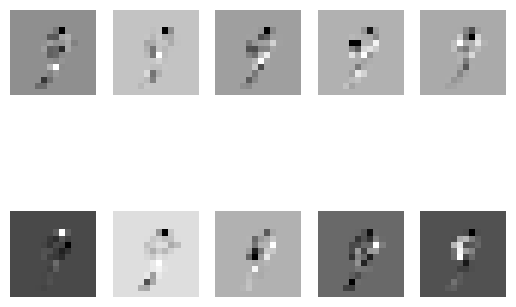

In [40]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(result[0][i], cmap='gray')
    plt.axis('off')

In [42]:
import torch.nn.functional as F
resized_images = F.interpolate(torch.tensor(result), size=(28, 28), mode='bilinear', align_corners=False).numpy()

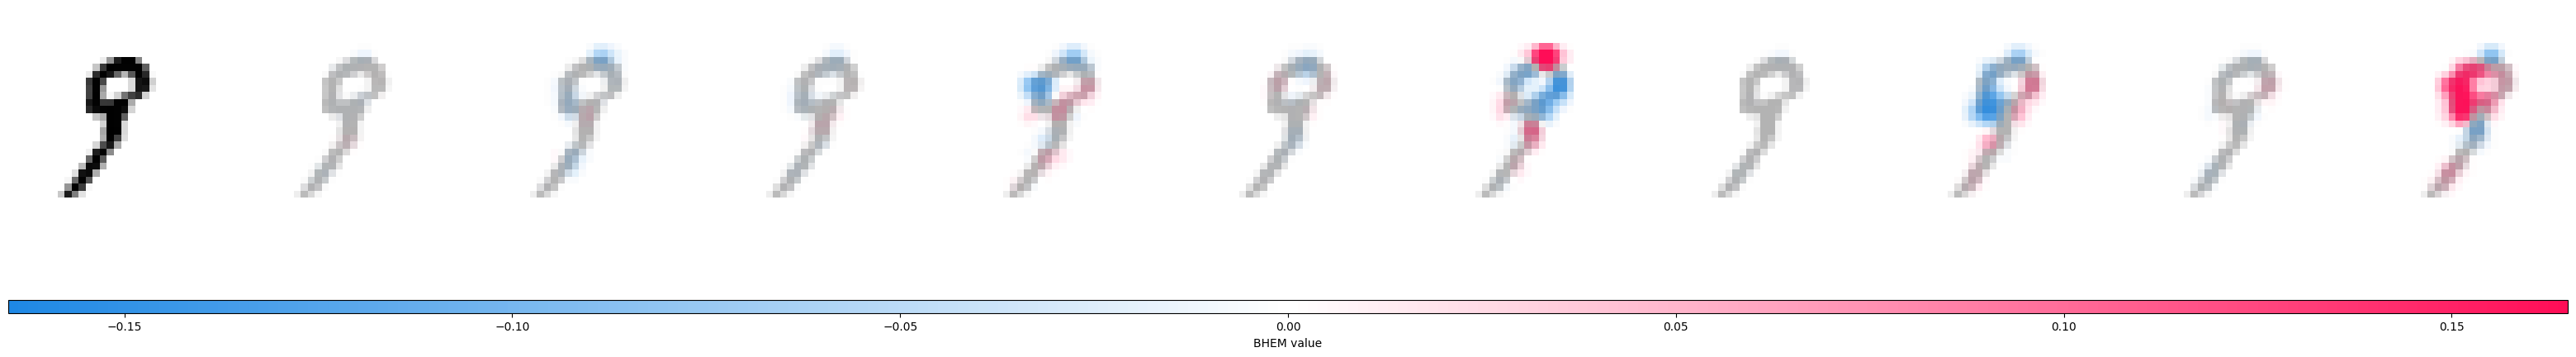

In [43]:
bhem_exp.plot_viz(result, resized_images)

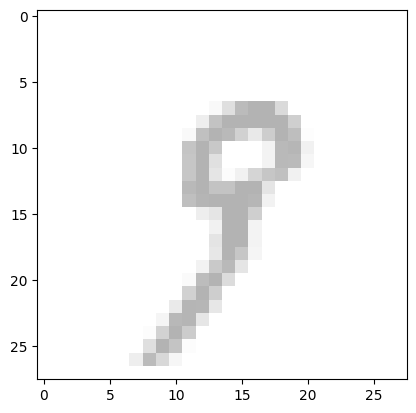

In [51]:
plt.imshow(bhem_exp.image, cmap='gray_r', alpha=0.3)

In [53]:
np.save(f'result_array_{img_ID}.npy', result)